https://stackoverflow.com/questions/24920346/filtering-a-wav-file-using-python

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import math
import contextlib
import numpy as np
import wave
import struct

## Set files

In [2]:
fname = "Feel_It_Still.wav"
outname = 'filtered.wav'

## Create fake .wav

In [3]:
def create_wav():
    freq = 440.0
    data_size = 40000
    frate = 11025.0  
    amp = 64000.0    

    sine_list_x = []
    for x in range(data_size):
        sine_list_x.append(np.sin(2*np.pi*freq*(x/frate)))

    wav_file = wave.open(fname, "w")

    nchannels = 1
    sampwidth = 2
    framerate = int(frate)
    nframes = data_size
    comptype = "NONE"
    compname = "not compressed"

    wav_file.setparams((nchannels, sampwidth, framerate, nframes,
    comptype, compname))

    for s in sine_list_x:
        wav_file.writeframes(struct.pack('h', int(s*amp/2)))

    wav_file.close()
    
    
# create_wav()

## Function to interprete .wav

In [4]:
# http://stackoverflow.com/questions/2226853/interpreting-wav-data/2227174#2227174
def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):
    """
    Given a file-like object or file path representing a wave file,
    decompose it into its constituent PCM data streams.

    Input: A file like object or file path
    Output: A list of lists of integers representing the PCM coded data stream channels
        and the sample rate of the channels (mixed rate channels not supported)
    """
    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels

## Running mean

In [5]:
# http://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def running_mean(x, windowSize):
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

## Filter .wav

In [6]:
cutOffFrequency = 10.0

with contextlib.closing(wave.open(fname,'rb')) as spf:
    # sampling frequency
    sampleRate = spf.getframerate()
    # width in bytes
    ampWidth = spf.getsampwidth()
    # mono(1) or stereo(2)
    nChannels = spf.getnchannels()
    # number of audio frames
    nFrames = spf.getnframes()

    # Extract raw audio from multi-channel .wav file
    # returns at most nFrames*nChannels as bytes object
    signal = spf.readframes(nFrames*nChannels)
    spf.close()
    channels = interpret_wav(signal, nFrames, nChannels, ampWidth, True)
    
    # get window size
    # http://dsp.stackexchange.com/questions/9966/what-is-the-cut-off-frequency-of-a-moving-average-filter
    freqRatio = (cutOffFrequency/sampleRate)
    N = int(math.sqrt(0.196196 + freqRatio**2)/freqRatio)

    # Use moving average (only on first channel)
    filtered = running_mean(channels[0], N).astype(channels.dtype)

    
    # Writes the result
    wav_file = wave.open(outname, "w")
    # getcomptype and getcompname returns the compression type
    wav_file.setparams((1, ampWidth, sampleRate, nFrames, spf.getcomptype(), spf.getcompname()))
    wav_file.writeframes(filtered.tobytes('C'))
    wav_file.close()

## Print the initial wave

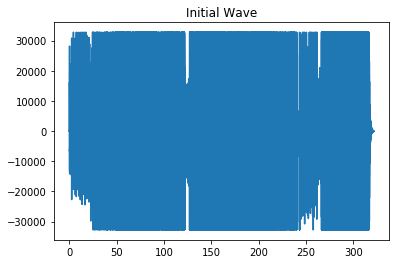

In [7]:
spf = wave.open(fname,'r')

signal = spf.readframes(-1)
signal = np.frombuffer(signal, 'int16')

fs = spf.getframerate()
Time=np.linspace(0, len(signal)/fs, num=len(signal))

plt.figure(1)
plt.title('Initial Wave')
plt.plot(Time, signal)

## Print filtered wave

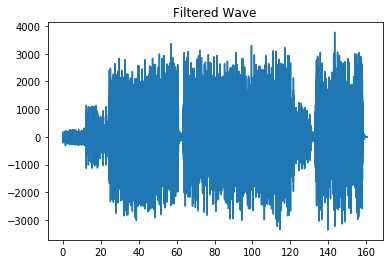

In [8]:
spf = wave.open(outname,'r')

signal = spf.readframes(-1)
signal = np.frombuffer(signal, 'int16')

fs = spf.getframerate()
Time=np.linspace(0, len(signal)/fs, num=len(signal))

plt.figure(1)
plt.title('Filtered Wave')
plt.plot(Time, signal)